In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import datetime as dt

warnings.filterwarnings("ignore")

In [2]:
def format_data(df):
    return (
        df.assign(
            site=lambda x: x["site_month"].str.split("_").str[0],
            date=lambda x: pd.to_datetime(
                x["site_month"].str.split("_").str[1:3].str.join(sep=""), format="%Y-%m"
            ),
            se=lambda x: x["se.fit"],
            slant=lambda x: x["fit"],
        )
        .assign(
            site=lambda x: np.where(
                (x["site"] == "mno.hu") & (x["date"] > "2018-06-01"),
                "mno.hu/magyaridok.hu",
                x["site"],
            )
        )
        .filter(["site", "date", "slant", "se"])
        .sort_values(by=["site", "date"])
    )


def detrend_time_series(df):
    return (
        df.merge(
            df.groupby("date")["slant"]
            .mean()
            .reset_index()
            .rename(columns={"slant": "mean_slant"}),
            on="date",
            how="left",
        )
        .assign(slant=lambda x: (x["slant"] - x["mean_slant"]) + x["slant"].mean())
        .drop(["mean_slant"], axis=1)
    )


def smooth_time_series(df, alpha=0.15):
    return df.assign(slant=df.groupby("site")["slant"].ewm(alpha=alpha).mean().values)


def melt_data_for_figure(df, z_score=1.96):
    return (
        df.assign(
            ci_lower=lambda x: x["slant"] - z_score * x["se"],
            ci_upper=lambda x: x["slant"] + z_score * x["se"],
        )
        .melt(
            id_vars=["site", "date"],
            value_vars=["slant", "ci_lower", "ci_upper"],
        )
        .assign(
            variable_type=lambda x: x["variable"],
            variable=lambda x: x["variable"].map(
                {"slant": "slant", "ci_upper": "ci", "ci_lower": "ci"}
            ),
        )
        .rename(columns={"value": "slant"})
        .sort_values(by=["site", "date"])
    )

def execute_formating():
    df = pd.concat(
        [
            pd.read_csv("../data/output/monthly_slant_pred_" + str(year) + ".csv")
            for year in range(2010, 2022)
        ]
    ).loc[lambda x: x["fit"] != 0]

    df = (
        df.pipe(format_data)
        .pipe(detrend_time_series)
        .pipe(smooth_time_series)
        .assign(se=lambda x: np.where(x["se"] > 0.01, 0.01, x["se"]))
        .pipe(melt_data_for_figure)
    )
    return df

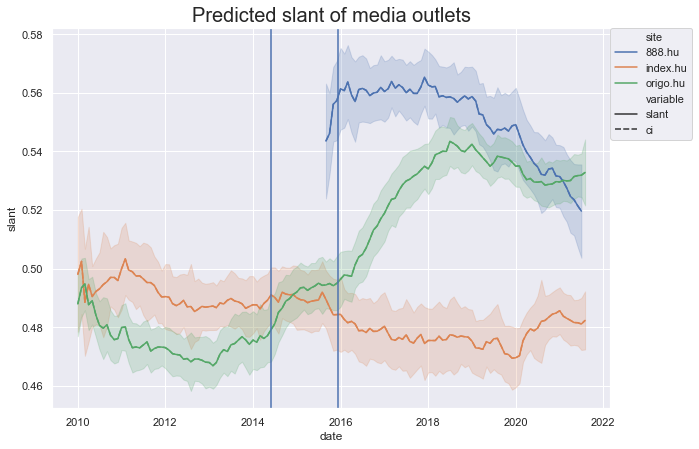

In [3]:
df = execute_formating().loc[
    lambda x: x["site"].isin(["index.hu", "origo.hu", "888.hu"])
]
figname = "slant_estimates_origo_case.png"


plt.figure(figsize=(10, 7))
sns.set_theme(style="darkgrid")
sns.lineplot(x="date", y="slant", hue="site", style="variable", data=df)
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.0)
plt.title("Predicted slant of media outlets", size=20)
plt.ylabel("slant")

# change of editor
plt.axvline(dt.datetime(2014,6,2))

# change of owner
plt.axvline(dt.datetime(2015, 12, 7))


plt.savefig("../figures/" + figname)
plt.show()

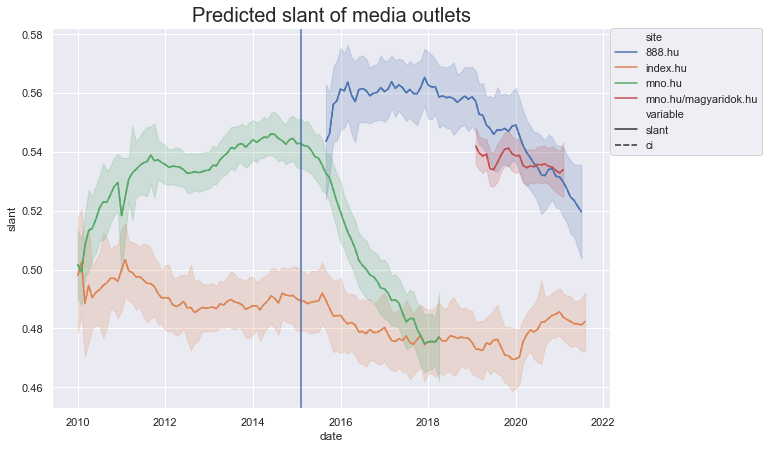

In [4]:
df = execute_formating().loc[
    lambda x: x["site"].isin(["index.hu", "mno.hu", "888.hu", "mno.hu/magyaridok.hu"])
]
figname = "slant_estimates_magyar_nemzet_case.png"


plt.figure(figsize=(10, 7))
sns.set_theme(style="darkgrid")
sns.lineplot(x="date", y="slant", hue="site", style="variable", data=df)
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.0)
plt.title("Predicted slant of media outlets", size=20)
plt.ylabel("slant")

# G nap
plt.axvline(dt.datetime(2015, 2, 6))

plt.savefig("../figures/" + figname)
plt.show()